# PROJECT TO DIVIDE PLAYERS INTO 4 CLUSTERS
### Good thing: Already know the number of clusters!

* Clustering players on skills: I have put a naive method for classifying players into midfield, attack, defense and goalkeeper. I want to see if clustering can segment players into such clear-cut segments. 

### USE CASE: A young player, who does not what is his calling; I will help him...

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import data_preprocess as dp
# Import supplementary visualization code visuals.py, renamed as visuals_udacity.py. I have taken this code from the Udacity
# machine learning projects
from Utils import *

# Pretty display for notebooks
%matplotlib inline
conn = dp.uncompress_and_open_sqlite()
print ("Players")
players_df = dp.sql_to_dataframe(conn, select_all_query_table("Player_Attributes"))
display(players_df.head(n=1))
display(players_df.dtypes)

player_names_df = dp.sql_to_dataframe(conn, select_all_query_table("Player"))


Players


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### Sampling players for validating clustering

In this code cell, I will take some popular players that I know about are in a particular category.



In [2]:
reload(dp)

# Calling helper function to get a dictionary mapping player names to Index.
player_names_df = dp.sql_to_dataframe(conn, select_all_query_table("Player"))

player_join_df = pd.merge(players_df, player_names_df, on='player_api_id',
                        how='outer', suffixes=('', '_y'))
player_join_df = player_join_df[player_join_df.columns.drop(list(player_join_df.filter(regex='_y')))]

player_join_df.date = pd.to_datetime(player_join_df.date)
player_join_df = player_join_df.sort_values(['date'], ascending=False)

ATTACKER_NAMES = ['Lionel Messi', 'Cristiano Ronaldo', 'Didier Drogba', 'Wayne Rooney', 'Eden Hazard', 'Thierry Henry']
attacker_player_row_indices = []
for attacker in ATTACKER_NAMES:
    attacker_df = player_join_df[player_join_df['player_name']== attacker]
    attacker_player_row_indices.append(attacker_df.index[0])

    
DEFENDER_NAMES = ['John Terry', 'Rio Ferdinand', 'Gerard Pique', 'Gary Neville', 'Jamie Carragher']
defender_player_row_indices = []
for defender in DEFENDER_NAMES:
    defender_df = player_join_df[player_join_df['player_name']== defender]
    defender_player_row_indices.append(defender_df.index[0])

GOALKEEPER_NAMES = ['Petr Cech', 'Iker Casillas', 'Joe Hart', 'Manuel Neuer']
goalkeeper_player_row_indices = []
for goalkeeper in GOALKEEPER_NAMES:
    goalkeeper_df = player_join_df[player_join_df['player_name']== goalkeeper]
    goalkeeper_player_row_indices.append(goalkeeper_df.index[0])

MIDFIELDER_NAMES = ['Frank Lampard', 'Xavi Hernandez', 'Andres Iniesta', 'Nemanja Matic']
midfielder_player_row_indices = []
for midfielder in MIDFIELDER_NAMES:
    midfielder_df = player_join_df[player_join_df['player_name']== midfielder]
    midfielder_player_row_indices.append(midfielder_df.index[0])

'''
attacker_player_row_indices = [102482, 43418, 33330]
defender_player_row_indices = [84848, 149835, 62977]
goalkeeper_player_row_indices = [142868, 72590, 83352]
midfielder_player_row_indices = [59244, 180709, 12773]
'''


# Create a DataFrame of the chosen samples
attacker_samples = pd.DataFrame(player_join_df.loc[attacker_player_row_indices], columns = player_join_df.keys()).reset_index(drop = True)
print "Chosen attacker samples of the players skills dataset"
display(attacker_samples)

defender_samples = pd.DataFrame(player_join_df.loc[defender_player_row_indices], columns = player_join_df.keys()).reset_index(drop = True)
print "Chosen defender samples of the players skills dataset"
display(defender_samples)

goalkeeper_samples = pd.DataFrame(player_join_df.loc[goalkeeper_player_row_indices], columns = player_join_df.keys()).reset_index(drop = True)
print "Chosen goalkeeper samples of the players skills dataset"
display(goalkeeper_samples)

midfielder_samples = pd.DataFrame(player_join_df.loc[midfielder_player_row_indices], columns = player_join_df.keys()).reset_index(drop = True)
print "Chosen midfielder samples of the players skills dataset"
display(midfielder_samples)

Chosen attacker samples of the players skills dataset


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight
0,102483,158023,30981,2015-12-17,94.0,94.0,left,medium,low,80.0,...,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24 00:00:00,170.18,159
1,33331,20801,30893,2015-10-16,93.0,93.0,right,high,low,82.0,...,23.0,7.0,11.0,15.0,14.0,11.0,Cristiano Ronaldo,1985-02-05 00:00:00,185.42,176
2,43419,31432,30822,2016-06-23,81.0,81.0,right,medium,low,67.0,...,29.0,10.0,11.0,8.0,6.0,14.0,Didier Drogba,1978-03-11 00:00:00,187.96,176
3,178941,54050,30829,2016-03-03,85.0,85.0,right,medium,high,78.0,...,37.0,10.0,11.0,13.0,8.0,7.0,Wayne Rooney,1985-10-24 00:00:00,175.26,183
4,47248,183277,107417,2016-01-28,88.0,90.0,right,high,medium,80.0,...,22.0,11.0,12.0,6.0,8.0,8.0,Eden Hazard,1991-01-07 00:00:00,172.72,163
5,169991,1625,30626,2015-07-03,79.0,79.0,right,medium,medium,63.0,...,25.0,10.0,12.0,7.0,10.0,10.0,Thierry Henry,1977-08-17 00:00:00,187.96,183


Chosen defender samples of the players skills dataset


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight
0,84830,13732,30627,2016-03-10,84.0,84.0,right,medium,high,42.0,...,84.0,14.0,5.0,6.0,15.0,8.0,John Terry,1980-12-07 00:00:00,187.96,198
1,149836,7289,30620,2015-05-01,75.0,75.0,right,medium,medium,45.0,...,77.0,12.0,9.0,5.0,9.0,5.0,Rio Ferdinand,1978-11-07 00:00:00,193.04,190
2,62978,152729,37482,2015-10-16,85.0,85.0,right,high,medium,57.0,...,83.0,10.0,11.0,14.0,15.0,8.0,Gerard Pique,1987-02-02 00:00:00,193.04,187
3,61730,244,30615,2010-08-30,76.0,82.0,right,None,_0,72.0,...,83.0,12.0,9.0,5.0,6.0,11.0,Gary Neville,1975-02-18 00:00:00,177.80,174
4,76644,5467,30617,2013-05-17,77.0,77.0,right,low,high,42.0,...,80.0,15.0,13.0,8.0,14.0,15.0,Jamie Carragher,1978-01-28 00:00:00,185.42,183


Chosen goalkeeper samples of the players skills dataset


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight
0,142869,48940,30859,2016-01-28,86.0,86.0,left,medium,medium,19.0,...,12.0,83.0,84.0,77.0,85.0,85.0,Petr Cech,1982-05-20 00:00:00,195.58,198
1,72591,5479,30657,2016-01-28,82.0,82.0,left,medium,medium,13.0,...,13.0,86.0,75.0,67.0,79.0,86.0,Iker Casillas,1981-05-20 00:00:00,185.42,185
2,83353,150724,31432,2016-01-28,84.0,84.0,right,medium,medium,14.0,...,13.0,84.0,81.0,75.0,84.0,88.0,Joe Hart,1987-04-19 00:00:00,195.58,201
3,109034,167495,27299,2016-04-21,90.0,90.0,right,medium,medium,15.0,...,11.0,85.0,87.0,91.0,90.0,87.0,Manuel Neuer,1986-03-27 00:00:00,193.04,203


Chosen midfielder samples of the players skills dataset


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight
0,59245,5471,30631,2016-05-12,77.0,77.0,right,medium,medium,79.0,...,57.0,12.0,14.0,15.0,10.0,8.0,Frank Lampard,1978-06-20 00:00:00,182.88,196
1,180710,10535,39854,2015-07-03,86.0,86.0,right,medium,medium,85.0,...,59.0,5.0,15.0,12.0,5.0,9.0,Xavi Hernandez,1980-01-25 00:00:00,170.18,148
2,12774,41,30955,2015-10-16,88.0,88.0,right,high,medium,79.0,...,56.0,6.0,13.0,6.0,13.0,7.0,Andres Iniesta,1984-05-11 00:00:00,170.18,150
3,131041,191202,115067,2016-04-21,83.0,84.0,left,medium,high,68.0,...,78.0,7.0,15.0,12.0,14.0,9.0,Nemanja Matic,1988-08-01 00:00:00,193.04,185


### Dropping metadata
We drop the metadata from all the data, and our player samples.
Just retaining only skill features from here, of type float64.

In [3]:
COLUMNS_NOT_NEEDED = ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential',
                      'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'player_name', 'date',
                     'birthday', 'height', 'weight']

# Drop columns from the dataset
players_skills_df = player_join_df.drop(COLUMNS_NOT_NEEDED, axis = 1)

# Drop columns for the samples taken
attacker_samples = attacker_samples.drop(COLUMNS_NOT_NEEDED, axis = 1)
defender_samples = defender_samples.drop(COLUMNS_NOT_NEEDED, axis = 1)
midfielder_samples = midfielder_samples.drop(COLUMNS_NOT_NEEDED, axis = 1)
goalkeeper_samples = goalkeeper_samples.drop(COLUMNS_NOT_NEEDED, axis = 1)

display (players_skills_df.dtypes)

crossing              float64
finishing             float64
heading_accuracy      float64
short_passing         float64
volleys               float64
dribbling             float64
curve                 float64
free_kick_accuracy    float64
long_passing          float64
ball_control          float64
acceleration          float64
sprint_speed          float64
agility               float64
reactions             float64
balance               float64
shot_power            float64
jumping               float64
stamina               float64
strength              float64
long_shots            float64
aggression            float64
interceptions         float64
positioning           float64
vision                float64
penalties             float64
marking               float64
standing_tackle       float64
sliding_tackle        float64
gk_diving             float64
gk_handling           float64
gk_kicking            float64
gk_positioning        float64
gk_reflexes           float64
dtype: obj

### Let's take all the features and see the cross-correlation between the features.

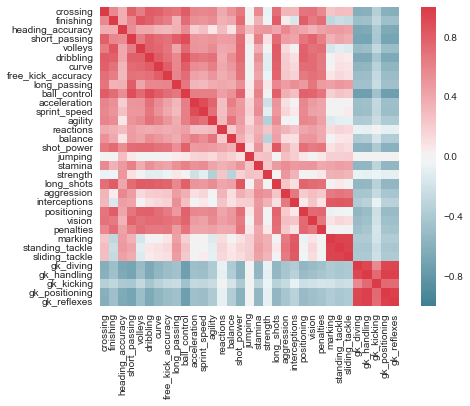

In [4]:
# Drop columns from them samples
import seaborn as sns
corr = players_skills_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)


#### Woo! That escalated quickly..

However, notice one thing, it is very clear that all columns that belong to a goalkeeper; are very clearly not correlated with any of the other features. This makes a lot of sense; as a goalkeeper depends on reflexes, and not a lot of stamina (as he is not running as much as other players).
This also suggests that we should try segregating features as we think would be relevant to a player's type.

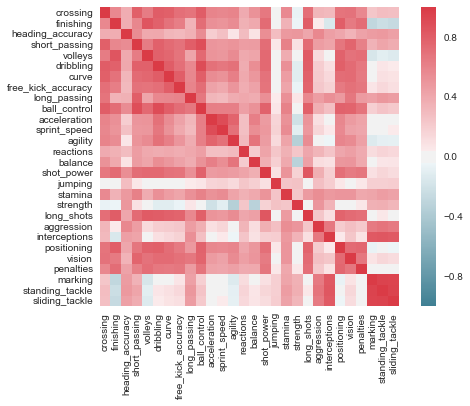

In [5]:
GK_FEATURE_COLUMNS = ['gk_diving' , 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
players_skills_df_minus_gk_features = players_skills_df.drop(GK_FEATURE_COLUMNS, axis = 1)
corr = players_skills_df_minus_gk_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

In [6]:
print ("Number of samples before removing cases of no data: " + str(players_skills_df.shape[0]))
players_skills_no_na_df = players_skills_df.dropna(axis = 0, how = 'any')
print ("Number of samples after removing cases of no data: " + str(players_skills_no_na_df.shape[0]))

from sklearn.decomposition import PCA
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=2)
pca.fit(players_skills_no_na_df)
print(pca.explained_variance_ratio_)  

Number of samples before removing cases of no data: 183978
Number of samples after removing cases of no data: 181265
[ 0.46598259  0.22098651]


## Acknowledgement: This code for visualization is taken from the Udacity Customer Segments' Project

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    
    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);
    
    player_color_map = {'attacker': 'black', 'defender' : 'orange', 'goalkeeper': 'green', 'midfielder': 'white'}
    for player_type in pca_samples:
        # Plot transformed sample points 
        list_samples = pca_samples[player_type]
        ax.scatter(x = pca_samples[player_type][:,0], y = pca_samples[player_type][:,1], \
                   s = 150, linewidth = 4, color = player_color_map[player_type], marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

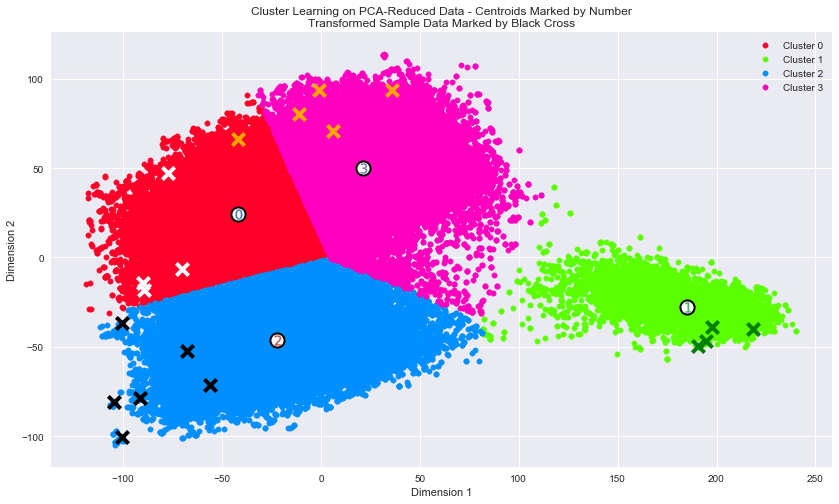

In [8]:
from sklearn.cluster import KMeans
NUMBER_OF_PLAYER_TYPES = 4
players_skills_no_na_reduced = pca.transform(players_skills_no_na_df)

# Apply pca on the samples - attack, defense, midfield etc.
pca_attacker_samples = pca.transform(attacker_samples)
pca_defender_samples = pca.transform(defender_samples)
pca_goalkeeper_samples = pca.transform(goalkeeper_samples)
pca_midfielder_samples = pca.transform(midfielder_samples)

pca_samples = dict()
pca_samples['attacker'] = pca_attacker_samples
pca_samples['defender'] = pca_defender_samples
pca_samples['goalkeeper'] = pca_goalkeeper_samples
pca_samples['midfielder'] = pca_midfielder_samples

# Create a DataFrame for the reduced data
players_skills_no_na_reduced_df = pd.DataFrame(players_skills_no_na_reduced, columns = ['Dimension 1', 'Dimension 2'])

kmeans = KMeans(n_clusters=NUMBER_OF_PLAYER_TYPES, random_state=0).fit(players_skills_no_na_reduced_df)

preds = kmeans.predict(players_skills_no_na_reduced_df)

cluster_results(reduced_data=players_skills_no_na_reduced_df, preds=preds, centers=kmeans.cluster_centers_, pca_samples= pca_samples)


In [9]:
sample_attacker_preds = kmeans.predict(pca_attacker_samples)
print sample_attacker_preds

sample_defender_preds = kmeans.predict(pca_defender_samples)
print sample_defender_preds

sample_goalkeeper_preds = kmeans.predict(pca_goalkeeper_samples)
print sample_goalkeeper_preds

sample_midfielder_preds = kmeans.predict(pca_midfielder_samples)
print sample_midfielder_preds

[2 2 2 2 2 2]
[3 3 0 3 3]
[1 1 1 1]
[0 0 0 0]


### Conclusion

* Notes on how the plsyers chosen are outliers, few of the best!

* How the goalkeeper cluster is so far away from everything else.

* How the mispredicted- Gerard Pique is a good finisher too! 